In [ ]:
import os
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from pathlib import Path
import random
from models.vqgan import GumbelVQ
from NudeNet.nudenet import nudenet
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from utils import *


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")
config_path = "checkpoints/config_openimages_gumbel.yaml"
ckpt_path = "checkpoints/check_openimages_gumbel.ckpt"

# Carica configurazione
config = OmegaConf.load(config_path)

# Crea il modello
model = GumbelVQ(**config['model']['params'])

# Carica pesi
checkpoint = torch.load(ckpt_path, map_location=device)
model.load_state_dict(checkpoint["state_dict"], strict=False)

model = model.to(device).eval()

print("\nVQGAN loaded successfully!")
detector = nudenet.NudeDetector()
print("NudeNet loaded successfully!")

Using device: cuda

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


/tmp/ipykernel_485297/2035192655.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)



VQGAN loaded successfully!
NudeNet loaded successfully!


# Retain set using masked explicit images (only for breasts)

In [3]:
index_codes_retain = torch.load('index_codes_masked_breasts.pt')
index_codes_retain[index_codes_retain>8191] = torch.zeros(1)
index_codes_porn = torch.load('/home/giorgiot/taming-transformers/index_codes_porn_train.pt')

/tmp/ipykernel_38343/1115838379.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  index_codes_retain = torch.load('index_codes_masked_breasts.pt')
/tmp/ipykernel_38343/111

In [4]:
explicit_codes, scores = compute_explicit_codes(index_codes_porn, index_codes_retain, K=250)
safe_codes = get_safe_codes(index_codes_retain, explicit_codes, min_freq=100)
mapping = generate_nearest_neighbor_map(model, explicit_codes, safe_codes, device)

Computing scores using Simple Frequency...
Mapping 250 explicit codes to 2636 safe candidates...


In [7]:
image_path = r'/media/pinas/datasets/nsfw_images_scraped/data/train/porn/ffff36f1d5b8c3b999d432c306d0580030b16f152a1dbac70baaaf5bbd66e4ad.jpg'
x = load_image_to_tensor(image_path, device=device)
x_fixed, indices, mask, z_q, z_q_modified = reconstruct_with_learned_map(model, x, detector, mapping, expand=0, min_score=0.6, device=device)

img = tensor_to_pil(x_fixed)
img.save("retain_breasts_test.png")
print(f"{mask.sum().item()} pixels replaced")

Number of latent codes changed: 27
110 pixels replaced


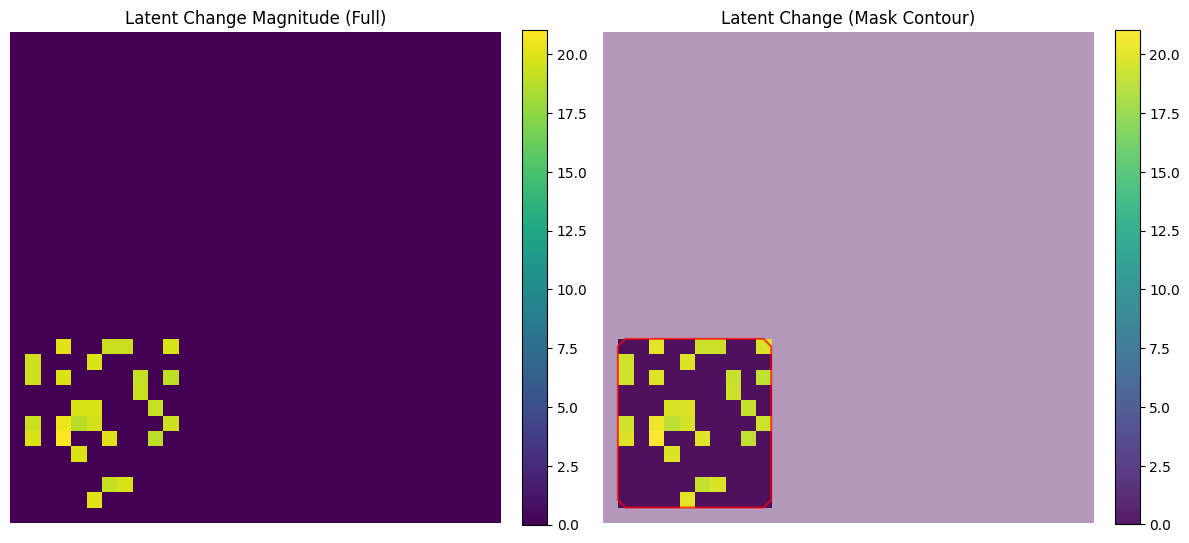

In [8]:
# Compute per-location L2 difference in latent space
latent_diff = z_q_modified - z_q                # [1, C, H_latent, W_latent]
latent_diff_mag = torch.norm(latent_diff, dim=1)  # [1, H_latent, W_latent]

latent_diff_mag_2d = latent_diff_mag[0].detach().cpu()
mask_latent_bool = mask[0].detach().cpu().bool()

# Compute pixel-space L2 difference
pixel_diff = x_fixed - x                       # [1, 3, H_img, W_img]
pixel_diff_mag = torch.norm(pixel_diff, dim=1) # [1, H_img, W_img]
pixel_diff_mag_2d = pixel_diff_mag[0].detach().cpu()


mask_img = F.interpolate(
    mask.float().unsqueeze(1),
    size=pixel_diff_mag_2d.shape,
    mode="nearest"
)[0, 0].bool().cpu()

overlay_latent = latent_diff_mag_2d.clone()
overlay_latent_np = overlay_latent.numpy()
mask_latent_np = mask_latent_bool.numpy()
overlay_latent_np[~mask_latent_np] = np.nan

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# --- Latent full ---
im0 = axes[0].imshow(latent_diff_mag_2d, cmap="viridis")
axes[0].set_title("Latent Change Magnitude (Full)")
axes[0].axis("off")
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# --- Latent masked overlay ---
axes[1].imshow(latent_diff_mag_2d, cmap="viridis", alpha=0.4)
im1 = axes[1].imshow(overlay_latent_np, cmap="viridis", alpha=0.9)
axes[1].contour(mask_latent_np, colors="red", linewidths=1.5, levels=[0.5], alpha=0.7)
axes[1].set_title("Latent Change (Mask Contour)")
axes[1].axis("off")
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [9]:
mask_latent_bool = mask[0].detach().cpu().bool()

inside = latent_diff_mag_2d[mask_latent_bool].mean()
outside = latent_diff_mag_2d[~mask_latent_bool].mean()

print(inside / outside)

tensor(inf)


# Reconstruction with a fixed random index 

In [ ]:
#image_path = r'/media/pinas/datasets/nsfw_images_scraped/data/test/porn/80cbf40eb2d4c2306b64ebe2bbd12d5b48160168c21b4f2b5bf105ebe0e8fd80.jpg'
x = load_image_to_tensor(image_path, image_size=256, device="cuda")

x_fixed, indices, mask = reconstruct_with_spatial_patching(model, x, detector, replacement_code=False, expand=0, min_score=0.5)

img = tensor_to_pil(x_fixed)
img.save("fixed_index_replacement.png")
print(f"{mask.sum().item()} pixels replaced")

Sostituiti 101 pixel


# Code Injection Test 

In [9]:
safe_img = r'/media/pinas/datasets/imagenet_zeus/val/n01494475/ILSVRC2012_val_00012879.JPEG'
explicit_img = r'/media/pinas/datasets/nsfw_images_scraped/data/test/porn/fca7e4fcb1a2b084413768b8557a3e619a4b0a0d72dbd39a88108c46b618d1b6.jpg'

x_safe = load_image_to_tensor(safe_img, image_size=256, device=device)
x_explicit = load_image_to_tensor(explicit_img, device=device, image_size=256)


x_codes_safe = model.encode(x_safe)[2][2]
x_codes_explicit = model.encode(x_explicit)[2][2]
_, _, mask, z_q, z_q_modified = reconstruct_with_spatial_patching(model, x_explicit, detector, mapping, device=device)

modified_image = inject_and_decode(model, x_codes_safe, x_codes_explicit, mask)
img = tensor_to_pil(modified_image)
z_q = model.encode(x_safe)[2][2]
z_q_modified = model.encode(modified_image)[2][2]
img.save("injected_image.png")

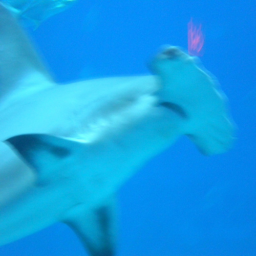

In [10]:
x_safe_img = tensor_to_pil(x_safe)
display(x_safe_img)

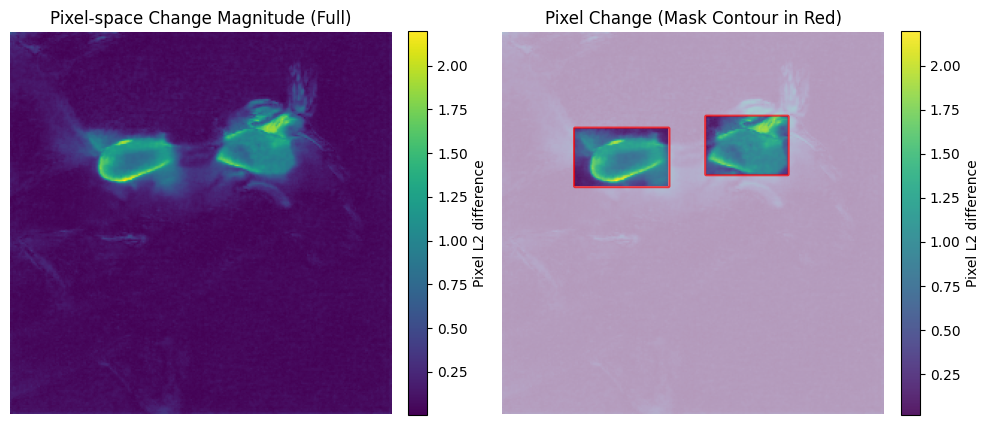

In [11]:
# Pixel-space difference
# Assuming x_fixed and x are float tensors of shape [1, 3, H_img, W_img]
pixel_diff = modified_image.detach().cpu() - x_safe.detach().cpu() # [1, 3, H_img, W_img]

# Per-pixel L2 distance across channels
pixel_diff_mag = torch.norm(pixel_diff, dim=1) # [1, H_img, W_img]

# Remove batch dimension
pixel_diff_mag_2d = pixel_diff_mag[0] # [H_img, W_img]

mask_latent = mask.float() # [1, H_latent, W_latent]

mask_img = F.interpolate(
    mask_latent.unsqueeze(1),  # [1, 1, H_latent, W_latent] (Add channel dimension)
    size=pixel_diff_mag_2d.shape, # (H_img, W_img)
    mode="nearest"
)

# Extract the boolean mask
mask_img_bool = mask_img[0, 0].bool().cpu() # [H_img, W_img]


overlay = pixel_diff_mag_2d.clone()

# Convert to numpy for np.nan assignment
overlay_np = overlay.numpy()
mask_img_np = mask_img_bool.numpy()

# Set unmasked areas to NaN
overlay_np[~mask_img_np] = np.nan


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

im0 = axes[0].imshow(pixel_diff_mag_2d, cmap="viridis")
axes[0].set_title("Pixel-space Change Magnitude (Full)")
axes[0].axis("off")
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, label="Pixel L2 difference")

axes[1].imshow(pixel_diff_mag_2d, cmap="viridis", alpha=0.4)

im1 = axes[1].imshow(overlay_np, cmap="viridis", alpha=0.9)

axes[1].contour(
    mask_img_np,
    colors="red",
    linewidths=1.5,
    levels=[0.5],
    alpha=0.7
)

axes[1].set_title("Pixel Change (Mask Contour in Red)")
axes[1].axis("off")
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04, label="Pixel L2 difference")

plt.tight_layout()
plt.show()

In [ ]:
indices_orig = z_q
indices_mod  = z_q_modified

# Flatten
flat_orig = indices_orig.view(-1)
flat_mod  = indices_mod.view(-1)

# Lookup embeddings
emb_orig = model.quantize.embed(flat_orig)
emb_mod  = model.quantize.embed(flat_mod)

# Reshape to latent grids: [1, C, H_latent, W_latent]
C = emb_orig.shape[-1]
H_latent, W_latent = indices_orig.shape[1], indices_orig.shape[2]

z_q_emb = emb_orig.view(1, H_latent, W_latent, C).permute(0, 3, 1, 2)
z_q_emb_mod = emb_mod.view(1, H_latent, W_latent, C).permute(0, 3, 1, 2)

latent_diff = z_q_emb_mod - z_q_emb                 # [1, C, H, W]
latent_diff_mag = torch.norm(latent_diff, dim=1)    # [1, H, W]

latent_diff_mag_2d = latent_diff_mag[0].detach().cpu()
mask_latent_bool = mask[0].detach().cpu().bool()

overlay = latent_diff_mag_2d.clone()
overlay_np = overlay.numpy()
mask_np = mask_latent_bool.numpy()

overlay_np[~mask_np] = np.nan

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

im0 = axes[0].imshow(latent_diff_mag_2d, cmap="RdPu")
axes[0].set_title("Latent-space Change Magnitude (Full)")
axes[0].axis("off")
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

axes[1].imshow(latent_diff_mag_2d, cmap="RdPu", alpha=0.4)
im1 = axes[1].imshow(overlay_np, cmap="RdPu", alpha=0.9)

axes[1].contour(
    mask_np,
    colors="red",
    linewidths=1.5,
    levels=[0.5],
    alpha=0.7
)

axes[1].set_title("Latent Change (Mask Contour)")
axes[1].axis("off")
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [20]:
mask_latent_bool = mask[0].detach().cpu().bool()

inside = latent_diff_mag_2d[mask_latent_bool].mean()
outside = latent_diff_mag_2d[~mask_latent_bool].mean()

print(inside / outside)


tensor(1.7552)


# Nearest Patch Replacement

## 🚧 Work in progress 🚧

In [3]:
index_codes_retain = torch.load('/home/giorgiot/taming-transformers/index_codes_retain_people.pt')
index_codes_retain = index_codes_retain.reshape(-1, 32, 32)
# print(index_codes_retain.shape)
index_codes_porn = torch.load('/home/giorgiot/taming-transformers/index_codes_porn_train.pt')
index_codes_porn = index_codes_porn.reshape(-1, 32, 32)
# print(index_codes_porn.shape)

/tmp/ipykernel_485297/2589873843.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  index_codes_retain = torch.load('/home/giorgiot/taming-transformers/index_codes_retain_p

In [9]:
patches_forget = extract_patches(index_codes_porn)
torch.save(patches_forget, 'patches_forget.pt')
print('Forget patches extracted!')

Forget patches extracted!


In [10]:
patches_retain = extract_patches(index_codes_retain)
torch.save(patches_retain, 'patches_retain.pt')
print('Forget retain extracted!')

Forget retain extracted!


In [5]:
patches_forget = torch.load('patches_forget.pt')
patches_retain = torch.load('patches_retain.pt')

/tmp/ipykernel_485297/1178291195.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patches_forget = torch.load('patches_forget.pt')
/tmp/ipykernel_485297/1178291195.py:2: 

In [ ]:
unique_patches, scores, count_f, count_r = score_patches(
    patches_forget,
    patches_retain,
    min_freq=10
)

In [ ]:
save_dict = {
    "unique_patches": unique_patches.cpu(),
    "counts_forget": count_f.cpu(),
    "counts_retain": count_r.cpu()
    }

torch.save(save_dict, "patch_stats.pt")

In [ ]:
explicit_patches, explicit_scores = select_explicit_patches(
    unique_patches,
    scores,
    K=None,
    threshold=2.5
)

In [ ]:
retain_patch_ids = extract_patch_ids(index_codes_retain)
retain_counter = Counter(retain_patch_ids)

explicit_patch_set = set(explicit_patches)

safe_patches = [
    p for p, c in retain_counter.items()
    if c >= 20 and p not in explicit_patch_set
]

In [ ]:
patch_replacement_map = build_patch_replacement_map(model, explicit_patches, safe_patches)

In [ ]:
image_path = r'/media/pinas/datasets/nsfw_images_scraped/data/train/porn/ffff36f1d5b8c3b999d432c306d0580030b16f152a1dbac70baaaf5bbd66e4ad.jpg'
x = load_image_to_tensor(image_path, device=device)

x_unlearned, final_indices, patch_mask, _, _ = reconstruct_with_patch_unlearning(
    model=model,
    x=x,  # [1, 3, H, W]
    explicit_patch_set=set(explicit_patches),
    patch_replacement_map=patch_replacement_map,
    patch_size=3
)

img = tensor_to_pil(x_fixed)
img.save("test_patches.png")
print(f"{patch_mask.sum().item()} pixels replaced")